In [4]:
!pwd
isLocalServer = True

/notebook/personal/ksuchoi216/faceID-model


In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, sys, os

if isLocalServer is True:
  sys_path_to_be_added = '/notebook/personal/ksuchoi216/faceID-model/'
  if not sys_path_to_be_added in sys.path:
    sys.path.insert(0, sys_path_to_be_added)
    os.chdir(sys_path_to_be_added)

  print(f'System path as follows:')
  for path in sys.path:
    print(f'    {path}')

def load_config():
  config_path = './configs/config_data_preparation.json'
  with open(config_path) as f:
    cfg = json.load(f)
  
  print(f'\nconfig file: {cfg}')
  
  return cfg
cfg = load_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System path as follows:
    /notebook/personal/ksuchoi216/faceID-model/
    /notebook/personal/ksuchoi216/face-id-model/
    /notebook
    /root/.pyenv/versions/3.9.1/lib/python39.zip
    /root/.pyenv/versions/3.9.1/lib/python3.9
    /root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload
    
    /root/.pyenv/versions/python39/lib/python3.9/site-packages

config file: {'data_source': './data/', 'folder_to_save': './data/photos_2m/', 'frame_count_limit': 300, 'frame_interval_for_sampling': 15, 'user_names': ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi'], 'video_names': ['1', '2', '3', '4'], 'data_preparation': {'path_folder_for_saved_images': './data/photos_2m/', 'path_folder_for_saving_cropped_faces': './data/photos_cropped/', 'image_size': 240, 'filter_with_face_prob': True, 'face_prob_threshold_for_filter': 0.9}}


# Images extracted from video(2m distance)

In [6]:
import cv2

cfg = load_config()
data_source = cfg['data_source']
folder_to_save = cfg['folder_to_save']
frame_count_limit = cfg['frame_count_limit']
frame_interval_for_sampling = cfg['frame_interval_for_sampling']

if not os.path.exists(folder_to_save):
  os.makedirs(folder_to_save)

user_names = cfg['user_names']
video_names = cfg['video_names']

for user_name, video_name in zip(user_names, video_names):
  path_for_video = data_source + 'video/'+video_name + '.mp4'
  path_for_username_folder = folder_to_save + user_name+'/'
  print(f'{path_for_video} with {path_for_username_folder}')
  
  if not os.path.exists(path_for_username_folder):
    os.makedirs(path_for_username_folder)
    
  vc = cv2.VideoCapture(path_for_video)
  success, frame = vc.read()

  count = 0
  frame_count = 0

  while success:
    success, frame = vc.read()
    if frame is not None:
      h, w, ch = frame.shape

      frame = frame[int(h*(1/4)):int(h*(3/4)), int(w*(2/5)): int(w*(3/5))]

      if frame_count == frame_count_limit:
        break

      count += 1
      if count%frame_interval_for_sampling == 0:
        path_for_save = path_for_username_folder + str(frame_count) + '.jpg'
        cv2.imwrite(path_for_save, frame)
        success, frame = vc.read()
        print(f'[{count:5}][{frame_count:4}] A image was saved at {path_for_save}')
        frame_count += 1





config file: {'data_source': './data/', 'folder_to_save': './data/photos_2m/', 'frame_count_limit': 300, 'frame_interval_for_sampling': 15, 'user_names': ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi'], 'video_names': ['1', '2', '3', '4'], 'data_preparation': {'path_folder_for_saved_images': './data/photos_2m/', 'path_folder_for_saving_cropped_faces': './data/photos_cropped/', 'image_size': 240, 'filter_with_face_prob': True, 'face_prob_threshold_for_filter': 0.9}}
./data/video/1.mp4 with ./data/photos_2m/jhyoo/
[   15][   0] A image was saved at ./data/photos_2m/jhyoo/0.jpg
[   30][   1] A image was saved at ./data/photos_2m/jhyoo/1.jpg
[   45][   2] A image was saved at ./data/photos_2m/jhyoo/2.jpg
[   60][   3] A image was saved at ./data/photos_2m/jhyoo/3.jpg
[   75][   4] A image was saved at ./data/photos_2m/jhyoo/4.jpg
[   90][   5] A image was saved at ./data/photos_2m/jhyoo/5.jpg
[  105][   6] A image was saved at ./data/photos_2m/jhyoo/6.jpg
[  120][   7] A image was saved at ./data

KeyboardInterrupt: 

# Preprocessing


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from external_library import MTCNN, InceptionResnetV1
import warnings
warnings.filterwarnings("ignore")

print(MTCNN)

<class 'external_library.facenet_pytorch.models.mtcnn.MTCNN'>


0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi


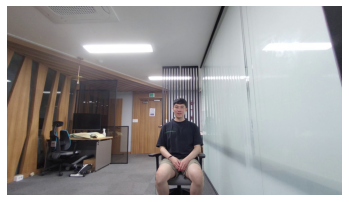

face shape: torch.Size([3, 500, 500]) / face prob: 0.9998080134391785


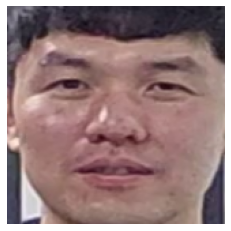

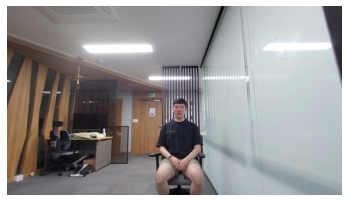

face shape: torch.Size([3, 500, 500]) / face prob: 0.9999693632125854


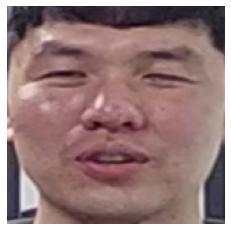

In [ ]:
# initializing MTCNN and InceptionResnetV1 
image_size = 500
mtcnn = MTCNN(image_size=image_size, margin=0, keep_all=False, min_face_size=image_size*0.1) # keep_all=False
mtcnn_multi = MTCNN(image_size=image_size, margin=0, keep_all=True, min_face_size=image_size*0.1) # keep_all=True
mtcnn_show = MTCNN(select_largest=False, post_process=False)
resnet = InceptionResnetV1(pretrained='vggface2').eval()


dataset = datasets.ImageFolder(folder_to_save) # photos folder path 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

for i,c in idx_to_class.items():
    print(i,c)

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

for i, (img, idx) in enumerate(loader):
    if i < 2:
        face, prob = mtcnn(img, return_prob=True)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print(f'face shape: {face.shape} / face prob: {prob}')
    
        face_test = mtcnn_show(img)
        plt.imshow(face_test.permute(1,2,0).int().numpy())
        plt.axis('off')
        plt.show()
    else:
        break


In [ ]:
from datasets import DataPreparation

cfg=load_config()
dataPreparation = DataPreparation(cfg['data_preparation'])
dataPreparation.save_cropped_faces()


config file: {'data_source': './data/', 'folder_to_save': './data/photos_2m/', 'frame_count_limit': 300, 'frame_interval_for_sampling': 30, 'user_names': ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi'], 'video_names': ['1', '2', '3', '4'], 'data_preparation': {'path_folder_for_saved_images': './data/photos_2m/', 'path_folder_for_saving_cropped_faces': './data/photos_cropped/', 'image_size': 240, 'filter_with_face_prob': True, 'face_prob_threshold_for_filter': 0.9}}
Starting data load...
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
saved cropped face image in  ./data/photos_cropped/jhoh/1.png
saved cropped face image in  ./data/photos_cropped/jhoh/2.png
saved cropped face image in  ./data/photos_cropped/jhoh/3.png
saved cropped face image in  ./data/photos_cropped/jhoh/4.png
saved cropped face image in  ./data/photos_cropped/jhoh/5.png
saved cropped face image in  ./data/photos_cropped/jhoh/6.png
saved cropped face image in  ./data/photos_cropped/jhoh/7.png
saved cropped face image in  ./data/photos_cro

In [ ]:
from PIL import Image
import numpy as np

def load_image(path) :
    img = Image.open(path)
    img.load()
    data = np.asarray(img)
    return data

cfg = load_config()
data_source = cfg['data_source']
path_folder_for_saved_images = cfg['data_preparation']['path_folder_for_saved_images']
path_folder_for_saving_cropped_faces = cfg['data_preparation']['path_folder_for_saving_cropped_faces']

user_names = cfg['user_names']
theNumberOfImages = cfg['theNumberOfImages']

for user_name in user_names:
  data_source_path = path_folder_for_saved_images+user_name+'/'
  # print(f'loading in {data_source_path}')
  numpy_img_list = []
  for i in range(theNumberOfImages):
    file_name = str(i)+'.jpg'
    file_path = data_source_path + file_name
    try: 
      numpy_img = load_image(file_path)
      # print(f'loaded from {file_path}')
    except:
      print(f'Failed loading image from the file path')
    numpy_img_list.append(numpy_img)      
    
  img_numpy = np.array(numpy_img_list)
  save_path = data_source + user_name + '_images.npy'
  np.save(save_path, img_numpy, allow_pickle=True)
  print(f'saved numpy file in {save_path}')